# RESUME NER MODEL TESTING

# !!!!!!!!! RETRAIN MODEL AFTER REMOVING RESUMES WITH NO LABEL AND SETTING A SEED FOR DATASET SPLIT !!!!!!!!!!!

In [148]:
import json
import os
import numpy as np
import pandas as pd
import datasets
import transformers
import evaluate
import tensorflow as tf
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

## Functions

In [149]:
def extract_tokens_from_resume(text):
    # Remove non-breaking spaces and normalize
    text = text.replace("\xa0", " ").strip()

    # Split on words, numbers, and punctuation
    tokens = re.findall(r'\w+|[^\w\s]', text, re.UNICODE)
    return tokens

## Test Dataset Preparation

In [154]:
datasetFolderPath = 'Dataset/'
labelEncoderDecoderPath = datasetFolderPath + 'LabelEncoderDecoder.json'

In [155]:
labelEncoderDecoder = json.load(open(labelEncoderDecoderPath, 'r'))
labelEncoder = labelEncoderDecoder['labelEncoder']
labelDecoder = labelEncoderDecoder['labelDecoder']
labelDecoder = {int(k): v for k, v in labelDecoder.items()}

In [156]:
datasetPath = 'Dataset/ResumeDataset.json'
dataset = json.load(open(datasetPath, 'r'))
dataset = datasets.Dataset.from_dict(dataset)
dataset

Dataset({
    features: ['id', 'text', 'annotations', 'input', 'NER_LABELS', 'NER_TAGS'],
    num_rows: 224
})

In [157]:
tokenizedDataset = dataset.map(tokenizerFunction, remove_columns=['input', 'NER_TAGS',  'NER_LABELS',  'text', 'annotations'])
tokenizedDataset

Map:   0%|          | 0/224 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 224
})

In [158]:
dataCollator = transformers.DataCollatorForTokenClassification(tokenizer=tokenizer, return_tensors='tf')
BATCH_SIZE = 4
tfDataset = tokenizedDataset.to_tf_dataset(
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=dataCollator,
)

In [159]:
trainDataset = tfDataset.take(int(len(tfDataset) * 0.9))
remDataset = tfDataset.skip(int(len(tfDataset) * 0.9))
valDataset = remDataset.take(int(len(remDataset) * 0.5))
testDataset = remDataset.skip(int(len(remDataset) * 0.5))

In [160]:
modelID = 'roberta-base'
modelPath = 'Models/' + 'ResumeNERModel-RoBERTaBase'
tokenizer = transformers.RobertaTokenizerFast.from_pretrained(modelID, add_prefix_space=True)
model = transformers.TFAutoModelForTokenClassification.from_pretrained(modelPath)

Some layers from the model checkpoint at Models/ResumeNERModel-RoBERTaBase were not used when initializing TFRobertaForTokenClassification: ['dropout_75']
- This IS expected if you are initializing TFRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaForTokenClassification were initialized from the model checkpoint at Models/ResumeNERModel-RoBERTaBase.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForTokenClassification for predictions without further training.


In [161]:
def alignLabelsWithTokens(labels, word_ids):
    newLabels = []
    currentWord = None
    for wordID in word_ids:
        if wordID is None:
            newLabels.append(-100)
        elif wordID != currentWord: # New Word
            currentWord = wordID
            newLabels.append(labels[wordID])
        else: # Same Word
            label = labels[wordID]
            newLabels.append(label)
    return newLabels

def tokenizerFunction(dataset):
    tokenized = tokenizer(dataset['input'], truncation=True, is_split_into_words=True, max_length=512, padding='max_length')
    tokenized['labels'] =  alignLabelsWithTokens(dataset['NER_TAGS'], tokenized.word_ids())
    return tokenized

## Testing

In [166]:
trueLabels = []
testInputs = []
for batch in testDataset:
    for i in range(len(batch['id'])):
        labels = batch['labels'][i].numpy()
        id = batch['id'][i].numpy()
        testInput = dataset['text'][dataset['id'].index(id)]
        testInputs.append(testInput)
        for i in range(len(labels)):
            if labels[i]==-100:
                labels[i] = 0
        trueLabels.extend(labels)
len(trueLabels), len(testInputs)

(6144, 12)

In [167]:
predLabels = []
for testInput in testInputs:
    modelInput = extract_tokens_from_resume(testInput)
    modelInput = tokenizer(modelInput, truncation=True, is_split_into_words=True, max_length=512, padding='max_length', return_tensors='tf')
    prediction = model(**modelInput).logits
    prediction = tf.argmax(prediction, axis=2).numpy()
    prediction = np.squeeze(prediction)
    predLabels.extend(prediction)
len(predLabels)

6144

In [169]:
print(predLabels[200:220])
print(trueLabels[200:220])

[28, 28, 27, 28, 28, 28, 28, 28, 7, 7, 8, 8, 8, 8, 8, 0, 69, 70, 70, 70]
[28, 28, 27, 28, 28, 28, 28, 28, 7, 7, 8, 8, 8, 8, 8, 0, 69, 70, 70, 70]


In [170]:
trueNames = [labelDecoder[i] for i in trueLabels]
predNames = [labelDecoder[i] for i in predLabels]
labelList = list(labelDecoder.values())

In [172]:
print(classification_report(trueNames, predNames, labels=labelList))

                            precision    recall  f1-score   support

                         O       1.00      0.99      0.99      4088
                B-learning       0.00      0.00      0.00         4
                I-learning       0.68      1.00      0.81        13
             B-researching       1.00      1.00      1.00         2
             I-researching       1.00      1.00      1.00         4
             B-soft-skills       1.00      0.56      0.71         9
             I-soft-skills       0.94      1.00      0.97        65
        B-work_with_people       1.00      1.00      1.00         6
        I-work_with_people       1.00      1.00      1.00        12
     B-commercial_thinking       0.00      0.00      0.00         0
     I-commercial_thinking       0.00      0.00      0.00         0
   B-place_basic_education       1.00      1.00      1.00        19
   I-place_basic_education       1.00      1.00      1.00        48
      B-adaption_to_change       0.83      0.71

/Users/aman/Documents/Academic/Santa Clara University/Spring 2025/SoftwareEngineering/Project/FinalProject/ScoreIt/ScoreItEnv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aman/Documents/Academic/Santa Clara University/Spring 2025/SoftwareEngineering/Project/FinalProject/ScoreIt/ScoreItEnv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aman/Documents/Academic/Santa Clara University/Spring 2025/SoftwareEngineering/Project/FinalProject/ScoreIt/ScoreItEnv/lib/python3.11/sit

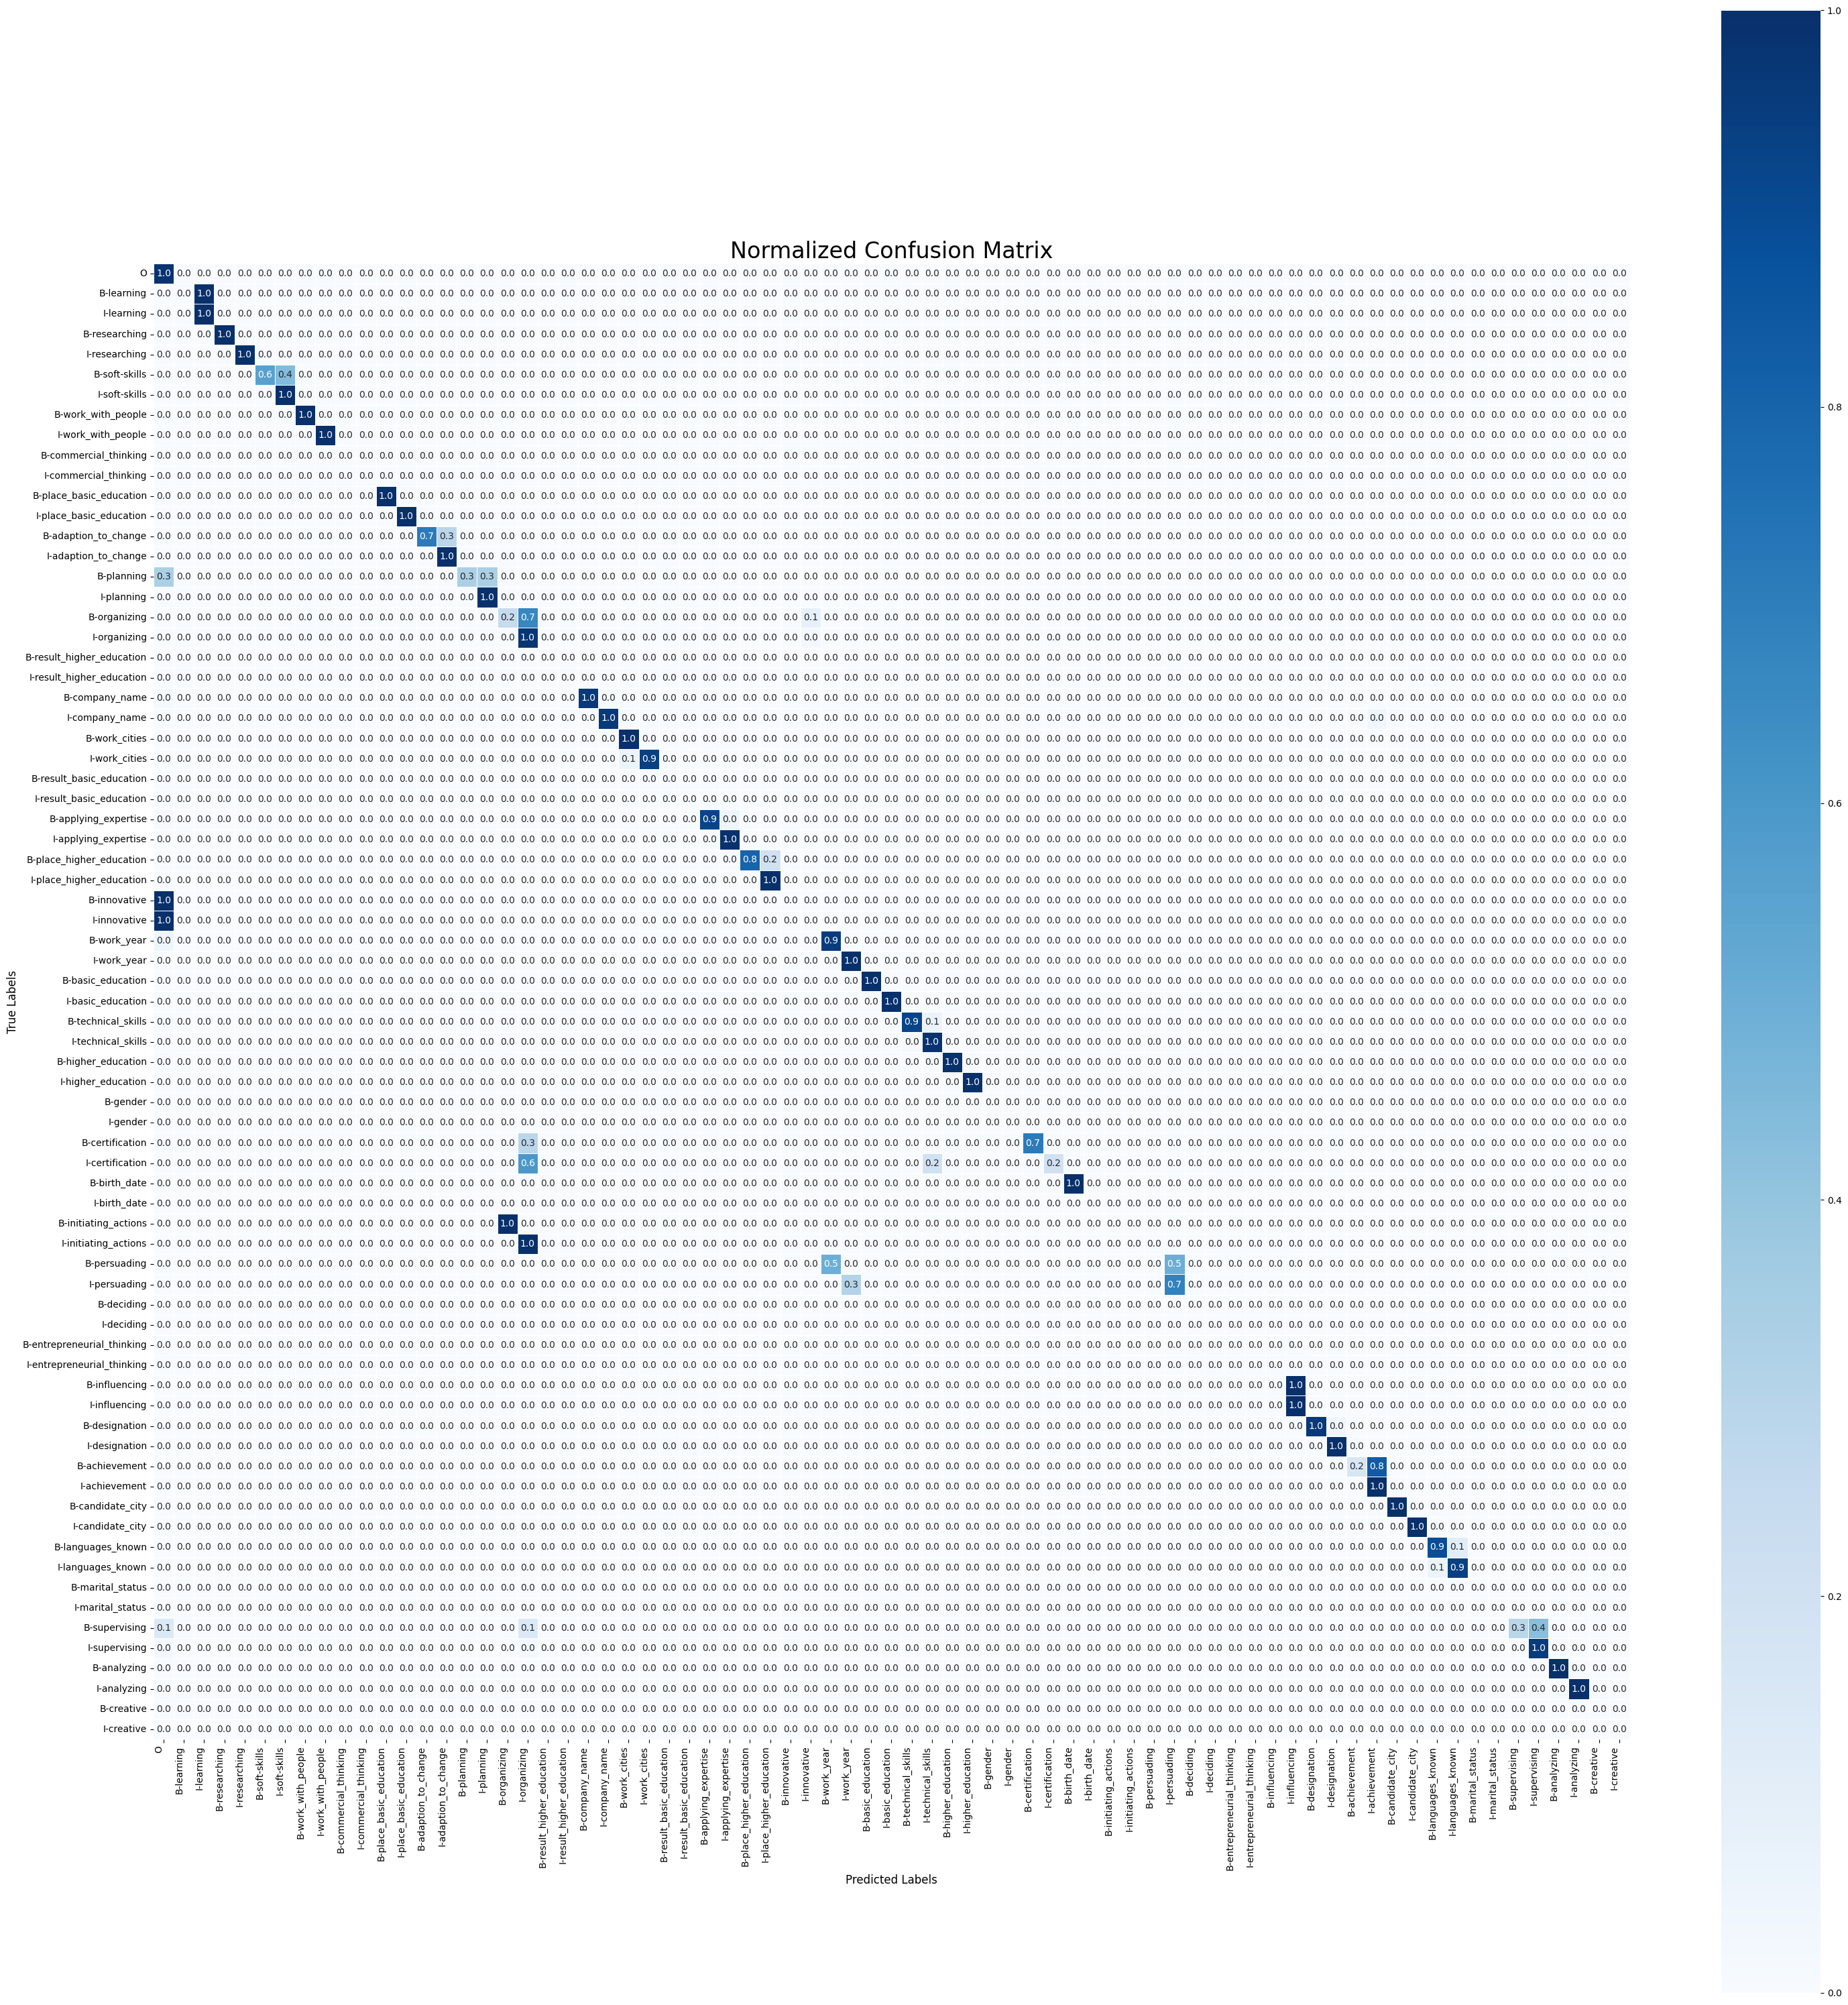

In [193]:
cm = confusion_matrix(trueNames, predNames, labels=labelList)

# Normalize the confusion matrix (optional, for better interpretability)
cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)

# Plot heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(cm_normalized, annot=True, fmt=".1f", 
            xticklabels=labelList, yticklabels=labelList, 
            cmap="Blues", cbar=True, linewidths=0.5, square=True)

plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Normalized Confusion Matrix", fontsize=24)
plt.xticks(rotation=90, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()